In [5]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [6]:
df_p1 = pd.read_csv("data1.csv")
df_p2 = pd.read_csv("data2.csv")
df_p3 = pd.read_csv("data70_140.csv")
df_p4 = pd.read_csv("data140_210.csv")
df_p5 = pd.read_csv("data210_310.csv")
df_p6 = pd.read_csv("data310_410.csv")
df_p7 = pd.read_csv("data410_500.csv")
df_p8 = pd.read_csv("data500_510.csv")

df = pd.concat([df_p1, df_p2, df_p3, df_p4, df_p5, df_p6, df_p7, df_p8]).drop_duplicates()

df = df.rename(columns={"orientation.1":"orientation_desc", "floor.1":"floor_desc", "antiquity.1":"antiquity_desc", "conservationState.1":"conservationState_desc", "hotWater.1":"hotWater_type_desc", "heating.1":"heating_desc"})
bool_features_cols = [
    'furnished','parking', 'Aire acondicionado', 'Parquet', 'Horno', 'Microondas',
    'Serv. portería', 'Balcón', 'Lavadero', 'Armarios', 'Calefacción',
    'Suite - con baño', 'Nevera', 'Puerta Blindada', 'Terraza',
    'Electrodomésticos', 'Alarma', 'Cocina Equipada', 'Lavadora',
    'Cocina Office', 'Patio', 'Videoportero', 'Piscina', 'Gres Cerámica',
    'Jardín Privado', 'Trastero', 'Internet', 'Domótica', 'TV',
    'Ascensor interior', 'Sistema Video vigilancia CCTV 24h',
    'Z. Comunitaria', 'Zona Deportiva', 'Zona Infantil',
    'Piscina comunitaria', 'Gimnasio', 'Baño de huéspedes',
    'Cuarto para el servicio', 'Jacuzzi', 'Bodega', 'Sauna',
    'Cuarto lavado plancha', 'Energía Solar', 'elevator', 'Pista de Tenis', 'Porche cubierto'
] # df.columns[45:87]

for colname in bool_features_cols:
    df[colname] = np.where(df[colname]>0, True, False)

df = df[df["value"]>0]
df = df[df["value"].notna()]
df = df[(df["surface"]>0) & (df["surface"].notna()) & (df["surface"] < 1000) & (df["energy_value"]<999)]

cols_drop = ["transactions", "transaction_type", "periodicity_id", "energyCertificate", "surfaceLand", "countryId", "level1Id",
             "level2Id", "level3Id", "level4Id", "level5Id", "level6Id", "level7Id", "level8Id",
             "conservationState", "orientation", "hotWater", "heating", "antiquity"] # , "floor"
try:
    df = df.drop(columns=cols_drop)
except:
    print("Some error ocurred. Maybe already dropped columns")

print(list(set(df.dtypes.to_list())))

def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliers_zscore(df, column, threshold=2):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores < threshold]

df_iqr = remove_outliers_iqr(df, "value") # df_iqr
df_z = remove_outliers_zscore(df, "value")

print(f"IQR: {len(df_iqr)} | Actual: {len(df)} | {(len(df_iqr)/len(df))*100:.2f}%")
print(f"IQR: {len(df_z)} | Actual: {len(df)} | {(len(df_z)/len(df))*100:.2f}%")

df = df_iqr.copy()
duplicates_columns = ["value", "energy_value", "energy_letter","environment_value", "rooms", "bathrooms", "surface", "floor", "upperLevel"]
df = df.drop_duplicates(subset=duplicates_columns, keep='first').reset_index(drop=True)
print(df.shape)

[dtype('O'), dtype('bool'), dtype('float64'), dtype('int64')]
IQR: 5774 | Actual: 6267 | 92.13%
IQR: 5998 | Actual: 6267 | 95.71%
(4437, 95)


In [7]:
# Defining salaries by district at 2022
salaries_district_gross = {
    "Eixample":38261,
    "Ciutat Vella":24921,
    "Sant Martí":33611,
    "Sarrià - Sant Gervasi":54999,
    "Sants - Montjuïc":29894,   
    "Horta - Guinardó":30696,
    "Gràcia":35923,
    "Nou Barris":24785,
    "Les Corts":42832,
    "Sant Andreu":30326,
}

salaries_district_inflation_gross = {}

for district in salaries_district_gross.keys():
    salaries_district_inflation_gross[district] = salaries_district_gross[district] + salaries_district_gross[district]*0.035

# assuming taxes considering 2 children
salaries_district_net_children = {
    "Eixample":29933,
    "Ciutat Vella":20884,
    "Sant Martí":26779,
    "Sarrià - Sant Gervasi":40490,
    "Sants - Montjuïc":24257,   
    "Horta - Guinardó":24802,
    "Gràcia":28349,
    "Nou Barris":20790,
    "Les Corts":32734,
    "Sant Andreu":24550
}

# assuming taxes considering no children
salaries_district_net_no_children = {
    "Eixample":29450,
    "Ciutat Vella":20399,
    "Sant Martí":26295,
    "Sarrià - Sant Gervasi":40000,
    "Sants - Montjuïc":23774,   
    "Horta - Guinardó":24316,
    "Gràcia":27862,
    "Nou Barris":20306,
    "Les Corts":32250,
    "Sant Andreu":24067
}

In [8]:
# preu - entrada hipoteca (per pis) = preu final --> mitjana de preu final
# flat value + 10% taxes - 20% entry
df["value_mortgage"] = df.value + (df.value*0.105) - (df.value*0.2)
print(np.mean(df["value_mortgage"]))

# mitjana de preu total - entrada hipoteca de la mitjana = preu final
print(np.mean(df["value"]) + (np.mean(df["value"])*0.105) - np.mean(df["value"]*0.2))


431939.13101645256
431939.1310164526


In [9]:
df["salary_net_children"] = df["level7"].replace(salaries_district_net_children)
df["salary_net_no_children"] = df["level7"].replace(salaries_district_net_no_children)

# assume people should not use more than 35% of their net salary in mortgage
df["salary_part_mortgage_children"] = df["salary_net_children"]*0.35
df["salary_part_mortgage_no_children"] = df["salary_net_no_children"]*0.35

In [10]:
from IPython.display import display, Math

display(Math(r'A = \frac{P \times r \times (1 + r)^n}{(1 + r)^n - 1}'))
display(Math(r'n = \frac{\ln\left(\frac{P \times r}{A - r \times P}\right)}{\ln(1 + r)}'))
display(Math(r'Dims: {}x{}m \\ Area: {}m^2 \\ Volume: {}m^3'.format(1, 2.5, 4, 5)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
# df["years_pay_mortgage_children"] = df["value_mortgage"] / df["salary_part_mortgage_children"]
# df["years_pay_mortgage_no_children"] = df["value_mortgage"] / df["salary_part_mortgage_no_children"]

In [14]:
#mean_value = df.groupby("level7")["value"].agg(["mean"]).rename(columns={"mean":"value_mean"})
#mean_salary = df.groupby("level7")["salary_net_children"].agg(["mean"]).rename(columns={"mean":"salary_mean"})
#mean_years = df.groupby("level7")["years_pay_mortgage_children"].agg(["mean"]).rename(columns={"mean":"years_mean"})

#years_pay_summary = pd.concat([mean_value, mean_salary, mean_years], axis=1).sort_values(by="years_mean", ascending=False)
#years_pay_summary

In [15]:
# important: assuming that the person who buys the flat, has the salary and lives at the same neighbor
# do it for the average bcn salary = 33837
# print("Average years of mortgage of people with 2 children, assuming 1 person:", np.mean(df.years_pay_mortgage_children))

In [16]:
# posant el que puguis permetre. t'ensenya els pisos

### Initial approach of mortgage costs

In [93]:
n_years = 31
tax = 0.03
initial_imp = 400000
imp = initial_imp + (initial_imp*0.105) - (initial_imp*0.2)

imp_year = imp / (n_years)
taxes = []
print("Imp per year: ", imp_year)
for i, year in enumerate(range(0,n_years)):
    print(f"Year: {year}, Taxes: {(imp-imp_year*year)*tax:.1f}, Remaining: {imp-imp_year*year:.1f}")
    taxes.append((imp-imp_year*year)*tax)

total_payment = np.sum(taxes) + imp
print("Total payment in taxes =", np.sum(taxes), "| Total payment mortgage =", total_payment)


Imp per year:  11677.41935483871
Year: 0, Taxes: 10860.0, Remaining: 362000.0
Year: 1, Taxes: 10509.7, Remaining: 350322.6
Year: 2, Taxes: 10159.4, Remaining: 338645.2
Year: 3, Taxes: 9809.0, Remaining: 326967.7
Year: 4, Taxes: 9458.7, Remaining: 315290.3
Year: 5, Taxes: 9108.4, Remaining: 303612.9
Year: 6, Taxes: 8758.1, Remaining: 291935.5
Year: 7, Taxes: 8407.7, Remaining: 280258.1
Year: 8, Taxes: 8057.4, Remaining: 268580.6
Year: 9, Taxes: 7707.1, Remaining: 256903.2
Year: 10, Taxes: 7356.8, Remaining: 245225.8
Year: 11, Taxes: 7006.5, Remaining: 233548.4
Year: 12, Taxes: 6656.1, Remaining: 221871.0
Year: 13, Taxes: 6305.8, Remaining: 210193.5
Year: 14, Taxes: 5955.5, Remaining: 198516.1
Year: 15, Taxes: 5605.2, Remaining: 186838.7
Year: 16, Taxes: 5254.8, Remaining: 175161.3
Year: 17, Taxes: 4904.5, Remaining: 163483.9
Year: 18, Taxes: 4554.2, Remaining: 151806.5
Year: 19, Taxes: 4203.9, Remaining: 140129.0
Year: 20, Taxes: 3853.5, Remaining: 128451.6
Year: 21, Taxes: 3503.2, Rema

### Simplified calculation of mortgage cost

In [96]:
n_years = 31
tax = 0.03
initial_imp = 400000
imp = initial_imp + (initial_imp*0.105) - (initial_imp*0.2)

net_salary = 50000
mortgage_salary = net_salary * 0.35

total_taxes = (n_years/2)*((imp*tax)+(imp_year*tax))
total_payment = imp + total_taxes

print("Total payment in taxes =", total_taxes, "| Total payment mortgage =", total_payment)
print("Total payment per year =", total_payment / n_years, "| Affordable salary =", mortgage_salary)
print("Can pay?", mortgage_salary > total_payment / n_years)

Total payment in taxes = 173760.0 | Total payment mortgage = 535760.0
Total payment per year = 17282.58064516129 | Affordable salary = 17500.0
Can pay? True


### Calculation of the optimal years to pay the mortgage depending on the salary

Imp before taxes =  362000.0
Anual salary to allocate towards the mortgage = 17500.0
Minimum taxes to pay = 173760.0
Minimum years to pay = 31


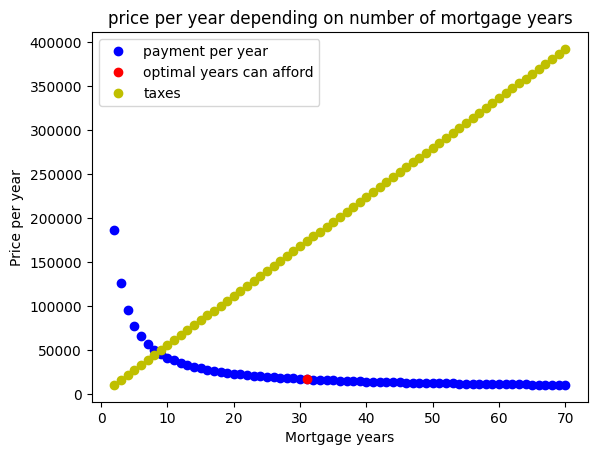

In [97]:
tax = 0.03
initial_imp = 400000
imp = initial_imp + (initial_imp*0.105) - (initial_imp*0.2)
print("Imp before taxes = ",imp)

net_salary = 50000
mortgage_salary = net_salary * 0.35
print("Anual salary to allocate towards the mortgage =", mortgage_salary)

n_years_list = np.arange(2,71)
payment_per_year_list = []
total_taxes_year_list = []
minimum_year_affordable = 70

for i, n_years in enumerate(n_years_list, start=2):
    total_taxes = (n_years/2)*((imp*tax)+(imp_year*tax))
    total_payment = imp + total_taxes
    payment_per_year = total_payment / n_years
    payment_per_year_list.append(payment_per_year)
    total_taxes_year_list.append(total_taxes)
    
    if (payment_per_year <= mortgage_salary) & (i<minimum_year_affordable):
        minimum_year_affordable = i
        payment_affordable = payment_per_year
        minimum_taxes_pay = total_taxes

print("Minimum taxes to pay =", minimum_taxes_pay)
print("Minimum years to pay =", minimum_year_affordable)
plt.plot(n_years_list, payment_per_year_list, 'bo', label='payment per year')
plt.plot(minimum_year_affordable, payment_affordable, 'ro', label='optimal years can afford')
plt.plot(n_years_list, total_taxes_year_list, 'yo', label='taxes')
plt.legend()
plt.title("price per year depending on number of mortgage years")
plt.xlabel("Mortgage years")
plt.ylabel("Price per year")
plt.show()
